In [1]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [2]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [3]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

In [4]:
def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [5]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

In [6]:
 class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 fused_window_process=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
            
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)
        self.fused_window_process = fused_window_process

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            if not self.fused_window_process:
                shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
                # partition windows
                x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
            else:
                x_windows = WindowProcess.apply(x, B, H, W, C, -self.shift_size, self.window_size)
        else:
            shifted_x = x
            # partition windows
            x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C

        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            if not self.fused_window_process:
                shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
                x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
            else:
                x = WindowProcessReverse.apply(attn_windows, B, H, W, C, self.shift_size, self.window_size)
        else:
            shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)

        # FFN
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

In [7]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

In [8]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 fused_window_process=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer,
                                 fused_window_process=fused_window_process)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

In [9]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

In [10]:
class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        fused_window_process (bool, optional): If True, use one kernel to fused window shift & window partition for acceleration, similar for the reversed part. Default: False
    """

    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=64, depths=[2, 2, 2, 2], num_heads=[2, 2, 2, 2],
                 window_size=16, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0, attn_drop_rate=0, drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, fused_window_process=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint,
                               fused_window_process=fused_window_process)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return 

In [11]:
model = SwinTransformer()
x = torch.randn(8, 3, 32, 32)  # Batch of 8 images with size 224x224 and 3 channels
output = model(x)
print(output.shape)

torch.Size([8, 10])


D:\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

In [13]:
batch_size = 64
learning_rate = 3e-4
train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

car


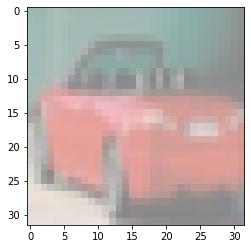

In [17]:
print(classes[labels[63]])
imshow(torchvision.utils.make_grid(images[63]))

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
num_epochs = 100
device = torch.device('cpu')

In [21]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())
        

  0%|                                                                                  | 1/782 [00:00<02:05,  6.23it/s]

Epoch: 0 Loss: 1.6944986581802368


  0%|                                                                                  | 1/782 [00:00<02:09,  6.02it/s]

Epoch: 1 Loss: 1.6313265562057495


  0%|                                                                                  | 1/782 [00:00<02:05,  6.23it/s]

Epoch: 2 Loss: 1.360778570175171


  0%|                                                                                  | 1/782 [00:00<02:06,  6.17it/s]

Epoch: 3 Loss: 1.2127615213394165


  0%|                                                                                  | 1/782 [00:00<02:06,  6.18it/s]

Epoch: 4 Loss: 0.9440473318099976


  0%|                                                                                  | 1/782 [00:00<02:02,  6.36it/s]

Epoch: 5 Loss: 0.9264213442802429


  0%|                                                                                  | 1/782 [00:00<02:27,  5.30it/s]

Epoch: 6 Loss: 1.1888165473937988


  0%|                                                                                  | 1/782 [00:00<02:07,  6.12it/s]

Epoch: 7 Loss: 1.1017628908157349


  0%|                                                                                  | 1/782 [00:00<02:06,  6.18it/s]

Epoch: 8 Loss: 0.8324505686759949


  0%|                                                                                  | 1/782 [00:00<02:09,  6.04it/s]

Epoch: 9 Loss: 0.1537601202726364


  0%|                                                                                  | 1/782 [00:00<02:00,  6.49it/s]

Epoch: 10 Loss: 0.28608113527297974


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 11 Loss: 0.19722872972488403


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 12 Loss: 0.5354380011558533


  0%|                                                                                  | 1/782 [00:00<02:05,  6.22it/s]

Epoch: 13 Loss: 0.5894556641578674


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 14 Loss: 0.452343225479126


  0%|                                                                                  | 1/782 [00:00<02:05,  6.21it/s]

Epoch: 15 Loss: 0.23885178565979004


  0%|                                                                                  | 1/782 [00:00<02:07,  6.14it/s]

Epoch: 16 Loss: 0.06288136541843414


  0%|                                                                                  | 1/782 [00:00<02:05,  6.24it/s]

Epoch: 17 Loss: 0.16386888921260834


  0%|                                                                                  | 1/782 [00:00<02:08,  6.08it/s]

Epoch: 18 Loss: 0.07221557199954987


  0%|                                                                                  | 1/782 [00:00<02:11,  5.93it/s]

Epoch: 19 Loss: 0.256629079580307


  0%|                                                                                  | 1/782 [00:00<02:05,  6.21it/s]

Epoch: 20 Loss: 0.10280296951532364


  0%|                                                                                  | 1/782 [00:00<02:06,  6.18it/s]

Epoch: 21 Loss: 0.03787050023674965


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 22 Loss: 0.1184287816286087


  0%|                                                                                  | 1/782 [00:00<01:57,  6.62it/s]

Epoch: 23 Loss: 0.012939291074872017


  0%|                                                                                  | 1/782 [00:00<02:12,  5.89it/s]

Epoch: 24 Loss: 0.07867208123207092


  0%|                                                                                  | 1/782 [00:00<02:06,  6.19it/s]

Epoch: 25 Loss: 0.013913387432694435


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 26 Loss: 0.0626918226480484


  0%|                                                                                  | 1/782 [00:00<02:06,  6.18it/s]

Epoch: 27 Loss: 0.19746817648410797


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 28 Loss: 0.034572720527648926


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 29 Loss: 0.11447436362504959


  0%|                                                                                  | 1/782 [00:00<02:03,  6.34it/s]

Epoch: 30 Loss: 0.19929787516593933


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 31 Loss: 0.039823297411203384


  0%|                                                                                  | 1/782 [00:00<02:14,  5.81it/s]

Epoch: 32 Loss: 0.08022838830947876


  0%|                                                                                  | 1/782 [00:00<02:11,  5.92it/s]

Epoch: 33 Loss: 0.2654210329055786


  0%|                                                                                  | 1/782 [00:00<02:11,  5.92it/s]

Epoch: 34 Loss: 0.04039248451590538


  0%|                                                                                  | 1/782 [00:00<02:06,  6.18it/s]

Epoch: 35 Loss: 0.017413191497325897


  0%|                                                                                  | 1/782 [00:00<02:05,  6.24it/s]

Epoch: 36 Loss: 0.0267783310264349


  0%|                                                                                  | 1/782 [00:00<02:20,  5.57it/s]

Epoch: 37 Loss: 0.02826387621462345


  0%|                                                                                  | 1/782 [00:00<02:05,  6.21it/s]

Epoch: 38 Loss: 0.004263180773705244


  0%|                                                                                  | 1/782 [00:00<02:06,  6.16it/s]

Epoch: 39 Loss: 0.23236052691936493


  0%|                                                                                  | 1/782 [00:00<02:03,  6.30it/s]

Epoch: 40 Loss: 0.02566665969789028


  0%|                                                                                  | 1/782 [00:00<02:12,  5.88it/s]

Epoch: 41 Loss: 0.038128457963466644


  0%|                                                                                  | 1/782 [00:00<02:07,  6.11it/s]

Epoch: 42 Loss: 0.017743799835443497


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 43 Loss: 0.015968620777130127


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 44 Loss: 0.021139565855264664


  0%|                                                                                  | 1/782 [00:00<02:11,  5.96it/s]

Epoch: 45 Loss: 0.11602747440338135


  0%|                                                                                  | 1/782 [00:00<02:03,  6.30it/s]

Epoch: 46 Loss: 0.003918089438229799


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 47 Loss: 0.010972997173666954


  0%|                                                                                  | 1/782 [00:00<02:06,  6.17it/s]

Epoch: 48 Loss: 0.021302536129951477


  0%|                                                                                  | 1/782 [00:00<02:05,  6.21it/s]

Epoch: 49 Loss: 0.09881292283535004


  0%|                                                                                  | 1/782 [00:00<02:05,  6.24it/s]

Epoch: 50 Loss: 0.010501086711883545


  0%|                                                                                  | 1/782 [00:00<02:05,  6.24it/s]

Epoch: 51 Loss: 0.18909692764282227


  0%|                                                                                  | 1/782 [00:00<02:13,  5.85it/s]

Epoch: 52 Loss: 0.05600738525390625


  0%|                                                                                  | 1/782 [00:00<02:06,  6.18it/s]

Epoch: 53 Loss: 0.19983351230621338


  0%|                                                                                  | 1/782 [00:00<02:04,  6.26it/s]

Epoch: 54 Loss: 0.018738115206360817


  0%|                                                                                  | 1/782 [00:00<02:13,  5.86it/s]

Epoch: 55 Loss: 0.10564171522855759


  0%|                                                                                  | 1/782 [00:00<02:07,  6.14it/s]

Epoch: 56 Loss: 0.0011637069983407855


  0%|                                                                                  | 1/782 [00:00<02:04,  6.28it/s]

Epoch: 57 Loss: 0.007063963916152716


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 58 Loss: 0.07293429970741272


  0%|                                                                                  | 1/782 [00:00<02:05,  6.23it/s]

Epoch: 59 Loss: 0.007608918473124504


  0%|                                                                                  | 1/782 [00:00<02:03,  6.35it/s]

Epoch: 60 Loss: 0.005074692890048027


  0%|                                                                                  | 1/782 [00:00<02:06,  6.19it/s]

Epoch: 61 Loss: 0.005268959328532219


  0%|                                                                                  | 1/782 [00:00<02:08,  6.10it/s]

Epoch: 62 Loss: 0.19147498905658722


  0%|                                                                                  | 1/782 [00:00<02:03,  6.35it/s]

Epoch: 63 Loss: 0.0031687517184764147


  0%|                                                                                  | 1/782 [00:00<02:03,  6.31it/s]

Epoch: 64 Loss: 0.0023378264158964157


  0%|                                                                                  | 1/782 [00:00<02:00,  6.48it/s]

Epoch: 65 Loss: 0.00311458483338356


  0%|                                                                                  | 1/782 [00:00<02:04,  6.30it/s]

Epoch: 66 Loss: 0.00852381344884634


  0%|                                                                                  | 1/782 [00:00<01:59,  6.53it/s]

Epoch: 67 Loss: 0.000699586933478713


  0%|                                                                                  | 1/782 [00:00<02:06,  6.19it/s]

Epoch: 68 Loss: 0.0010613902704790235


  0%|                                                                                  | 1/782 [00:00<02:05,  6.22it/s]

Epoch: 69 Loss: 0.0014257985167205334


  0%|                                                                                  | 1/782 [00:00<02:06,  6.19it/s]

Epoch: 70 Loss: 0.03638749569654465


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 71 Loss: 0.03568188473582268


  0%|                                                                                  | 1/782 [00:00<02:07,  6.12it/s]

Epoch: 72 Loss: 0.01443334948271513


  0%|                                                                                  | 1/782 [00:00<02:01,  6.43it/s]

Epoch: 73 Loss: 0.016647376120090485


  0%|                                                                                  | 1/782 [00:00<02:08,  6.07it/s]

Epoch: 74 Loss: 0.013147645629942417


  0%|                                                                                  | 1/782 [00:00<02:05,  6.21it/s]

Epoch: 75 Loss: 0.0010055697057396173


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 76 Loss: 0.07385323196649551


  0%|                                                                                  | 1/782 [00:00<02:12,  5.90it/s]

Epoch: 77 Loss: 0.3237672746181488


  0%|                                                                                  | 1/782 [00:00<02:06,  6.19it/s]

Epoch: 78 Loss: 0.12979355454444885


  0%|                                                                                  | 1/782 [00:00<02:03,  6.30it/s]

Epoch: 79 Loss: 0.006624915171414614


  0%|                                                                                  | 1/782 [00:00<02:06,  6.17it/s]

Epoch: 80 Loss: 0.029891593381762505


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 81 Loss: 0.00016160593077074736


  0%|                                                                                  | 1/782 [00:00<02:03,  6.35it/s]

Epoch: 82 Loss: 0.00015726828132756054


  0%|                                                                                  | 1/782 [00:00<02:05,  6.21it/s]

Epoch: 83 Loss: 0.27211788296699524


  0%|                                                                                  | 1/782 [00:00<02:16,  5.73it/s]

Epoch: 84 Loss: 0.07282628864049911


  0%|                                                                                  | 1/782 [00:00<02:05,  6.23it/s]

Epoch: 85 Loss: 0.0006954362033866346


  0%|                                                                                  | 1/782 [00:00<02:01,  6.45it/s]

Epoch: 86 Loss: 0.09568220376968384


  0%|                                                                                  | 1/782 [00:00<02:03,  6.31it/s]

Epoch: 87 Loss: 0.0004955156473442912


  0%|                                                                                  | 1/782 [00:00<02:03,  6.35it/s]

Epoch: 88 Loss: 0.005161729641258717


  0%|                                                                                  | 1/782 [00:00<02:08,  6.08it/s]

Epoch: 89 Loss: 0.0026422066148370504


  0%|                                                                                  | 1/782 [00:00<01:57,  6.67it/s]

Epoch: 90 Loss: 0.0009374195942655206


  0%|                                                                                  | 1/782 [00:00<02:02,  6.38it/s]

Epoch: 91 Loss: 0.007922778837382793


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 92 Loss: 0.0010662393178790808


  0%|                                                                                  | 1/782 [00:00<02:10,  5.99it/s]

Epoch: 93 Loss: 0.1082068383693695


  0%|                                                                                  | 1/782 [00:00<02:04,  6.27it/s]

Epoch: 94 Loss: 0.007276899181306362


  0%|                                                                                  | 1/782 [00:00<02:05,  6.22it/s]

Epoch: 95 Loss: 0.000665763858705759


  0%|                                                                                  | 1/782 [00:00<02:10,  6.00it/s]

Epoch: 96 Loss: 0.00024531333474442363


  0%|                                                                                  | 1/782 [00:00<01:59,  6.51it/s]

Epoch: 97 Loss: 0.06109916791319847


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 98 Loss: 0.13492217659950256


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [02:02<00:00,  6.39it/s]

Epoch: 99 Loss: 0.015380332246422768


In [22]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

index number: 0


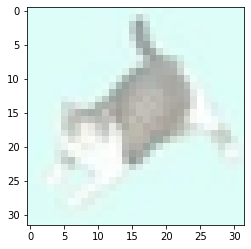

true label: cat
predict label: plane
index number: 1


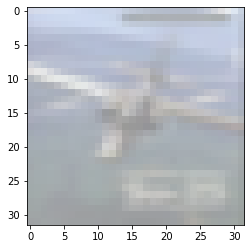

true label: plane
predict label: plane
index number: 2


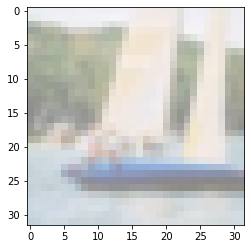

true label: ship
predict label: ship
index number: 3


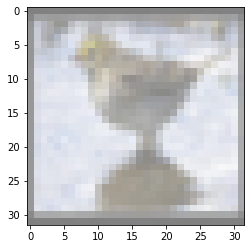

true label: bird
predict label: bird
index number: 4


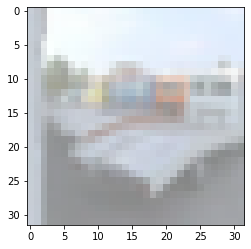

true label: truck
predict label: plane
index number: 5


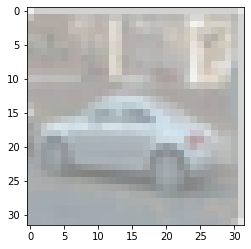

true label: car
predict label: car
index number: 6


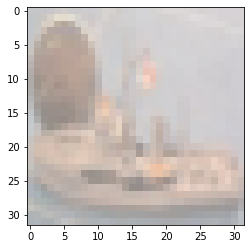

true label: ship
predict label: ship
index number: 7


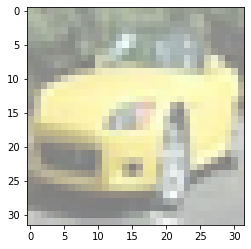

true label: car
predict label: car
index number: 8


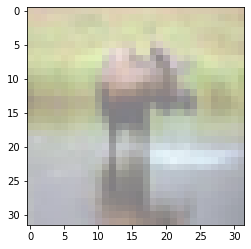

true label: deer
predict label: bird
index number: 9


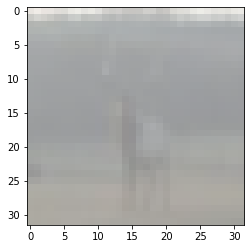

true label: deer
predict label: deer
index number: 10


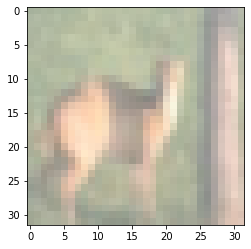

true label: deer
predict label: deer
index number:  


In [23]:
while True:
    i = input("index number: ")
    if i == ' ':
        break
    i = int(i)
    imshow(torchvision.utils.make_grid(images[i]))
    print('true label:',classes[labels[i]])
    prediction = model(images.to(device=device))
    max_index = np.argmax(prediction[i,:].detach().numpy())
    print('predict label:',classes[max_index])